# Land Parcel Identification System (LPIS) prediction for Slovenia

This notebook shows the steps towards constructing machine learning model for LPIS prediction for Slovenia.

### Overview

#### Requirements
1. Downloaded and processed Sentinel data *(relevant [notebook](https://github.com/sentinel-hub/eo-learn/blob/master/examples/land-cover-map/SI_LULC_pipeline.ipynb))*
    * Sentinel-2 data download
    * cloud detection and masking
    * interpolation    
    

2. Downloaded and grouped LPIS data *(relevant [notebook](LPISDataFromGeopedija.ipynb))*
    * LPIS data download
    * LPIS class grouping 
    
#### Samples construction
1. Data sample construction
    * edge mask construction
    * oversampling
2. Feature calculation
    * stream feature calculation
    * elevation
    
#### Feature selection and model construction
1. Feature selection
    * FASTENER
2. Model construction
    * data normalization
    * model training
    * model testing
3. Model usage
    * prediction of LPIS on chosen region



In [6]:
# Firstly, some necessary imports
import os
import numpy as np

seed = 42
np.random.seed(seed)

import matplotlib.pyplot as plt

# from eolearn.mask import EdgeExtractionTask
# from eolearn.geometry import BalancedClassSampler, BalancedClassSamplerTask
from notebook_temporary.edge_extraction import EdgeExtractionTask  # Change once it will be in develop
from notebook_temporary.sampling import BalancedClassSampler, \
    BalancedClassSamplerTask  # Change once it will be in develop

from eolearn.core import EOTask, EOPatch, LinearWorkflow, FeatureType, OverwritePermission, \
    LoadTask, SaveTask, EOExecutor
from eolearn.io import SentinelHubDemTask


## Samples construction

### Edge mask calculation
When training the classifier we don't want to include the pixels on the borders of parcels. These pixels are potential mixed-class instances that can have a negative effect on the learning process. So prior to sampling we will construct an timeless mask which excludes the edges. This is already done in an EOTask so we just need to call it.

Since we will be classificating crops we will calculate edges based on the NDVI metric and the green band. Along those, let's calculate all the metrics that we will be needing later which are the other base bands red, blue, NIR (Near infra red) and the vegetation related indices NIR, ARVI, EVI, NDVI, NDWI, SIPI and SAVI.

In [2]:
class AddBaseFeatures(EOTask):

    def __init__(self, c1=6, c2=7.5, L=1, Lvar=0.5, delta=10 ** -10):
        self.c1 = c1
        self.c2 = c2
        self.L = L
        self.Lvar = Lvar

        # We add a small number that doesn't significantly change the result to avoid divisions by zero
        self.delta = delta

    def execute(self, eopatch):
        nir = eopatch.data['BANDS'][..., [7]]
        blue = eopatch.data['BANDS'][..., [1]]
        red = eopatch.data['BANDS'][..., [3]]
        eopatch.add_feature(FeatureType.DATA, 'NIR', nir)

        arvi = np.clip((nir - (2 * red) + blue) / (nir + (2 * red) + blue + self.delta), -1, 1)
        eopatch.add_feature(FeatureType.DATA, 'ARVI', arvi)

        evi = np.clip(2.5 * ((nir - red) / (nir + (self.c1 * red) - (self.c2 * blue) + self.L + self.delta)), -1, 1)
        eopatch.add_feature(FeatureType.DATA, 'EVI', evi)

        ndvi = np.clip((nir - red) / (nir + red + self.delta), -1, 1)
        eopatch.add_feature(FeatureType.DATA, 'NDVI', ndvi)

        ndwi = np.clip((blue - red) / (blue + red + self.delta), -1, 1)
        eopatch.add_feature(FeatureType.DATA, 'NDWI', ndwi)

        sipi = np.clip((nir - blue) / (nir - red + self.delta), 0, 2)
        eopatch.add_feature(FeatureType.DATA, 'SIPI', sipi)

        savi = np.clip(((nir - red) / (nir + red + self.Lvar + self.delta)) * (1 + self.Lvar), -1, 1)
        eopatch.add_feature(FeatureType.DATA, 'SAVI', savi)

        return eopatch

In [3]:
base = AddBaseFeatures()
edges = EdgeExtractionTask(features={FeatureType.DATA: ['NDVI', 'GREEN']})

# This tutorial assumes all the patches are saved in current directory in folder patches. You can change this here
patches_path = f'{os.path.abspath(os.getcwd())}/patches'
# save_patch_location = patches_path
# save_path = f'{os.path.abspath(os.getcwd())}/patches_output'
save_path = patches_path
load = LoadTask(patches_path)
if not os.path.isdir(save_path):
    os.makedirs(save_path)
save = SaveTask(save_path, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

execution_args = []
for name in next(os.walk(patches_path))[1]:
    execution_args.append({
        load: {'eopatch_folder': name},
        save: {'eopatch_folder': name}
    })

workflow = LinearWorkflow(load,
                          base,
                          edges,
                          save)

executor = EOExecutor(workflow, execution_args)
executor.run(multiprocess=True)

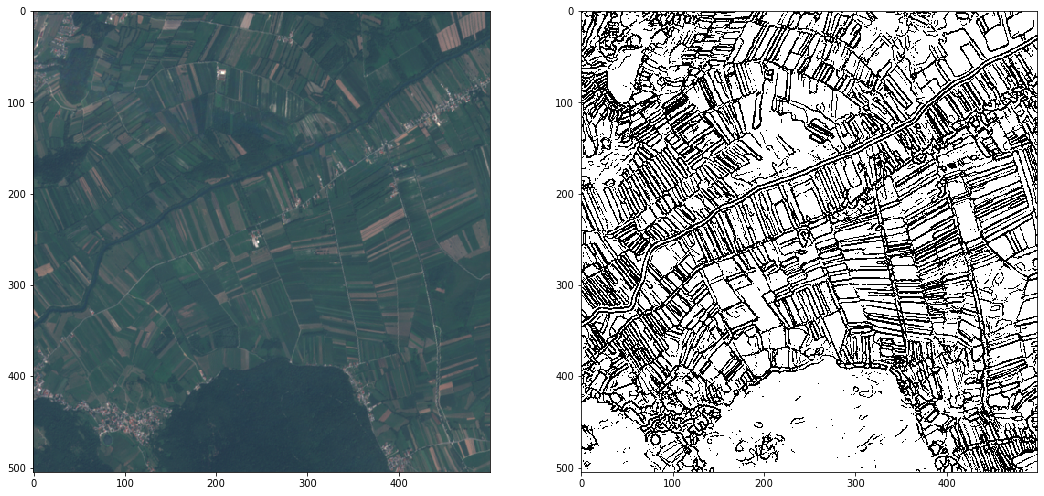

In [4]:
# Visualize the mask

patch_name = next(os.walk(patches_path))[1][0]
eopatch = EOPatch.load(f'{save_path}/{patch_name}')

edges = eopatch.mask_timeless['EDGES_INV'].squeeze()
img = np.clip(eopatch.data['BANDS'][10][..., [3, 2, 1]] * 3.5, 0, 1)

plt.figure(figsize=(18, 9))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(edges, cmap='gray')
plt.show()

### Sampling
We don't want to train a classifier on every point as earth observation data can be very large and thus unfeasible. In this step we will choose a sample of the area. The properties of a sample should be that it is taken from all region uniformly and because we are training a classifier we want to have each class represented equally. This can be done with the BalancedClassSampler task. We will also exclude the the edge regions we calculated before to have a "clean" sample.

In [12]:
class_feature = (FeatureType.MASK_TIMELESS, 'LPIS_2017')
sampler = BalancedClassSampler(class_feature=class_feature,
                               valid_mask=(FeatureType.MASK_TIMELESS, 'EDGES_INV'),
                               seed=seed)
sampler.sample_folder(save_path, lazy_loading=True)
distribution = sampler.get_prior_class_distribution()

# sorting so we can easier see which classes are less represented
distribution = {k: v for k, v in sorted(distribution.items(), key=lambda item: item[1])}

# Lets display what was sampled
print(distribution)

# We can try to increase the smallest samples classes by sampling again and this time specifying which classes
# are weak to do additional sampling around them once encountered
sampler2 = BalancedClassSampler(class_feature=class_feature,
                               valid_mask=(FeatureType.MASK_TIMELESS, 'EDGES_INV'),
                               seed=seed,
                               weak_classes=[6, 7, 5, 3])
sampler2.sample_folder(save_path, lazy_loading=True)
distribution2 = sampler2.get_prior_class_distribution()
distribution2 = {k: v for k, v in sorted(distribution2.items(), key=lambda item: item[1])}
print(distribution2)

# Final samples
samples = sampler2.get_balanced_data()
print(samples)

{3: 18, 6: 40, 7: 46, 5: 72, 8: 97, 11: 148, 10: 187, 4: 596, 13: 1539, 9: 1553, 2: 12003, 1: 26233, 0: 58468}
{8: 97, 3: 125, 11: 148, 10: 187, 6: 216, 7: 262, 5: 519, 4: 596, 13: 1539, 9: 1553, 2: 12003, 1: 26233, 0: 58468}
     LPIS_2017 patch_identifier    x    y
0            0      eopatch_396  315   44
1            0      eopatch_418  138  476
2            0      eopatch_396  157   78
3            0      eopatch_418  129  208
4            0      eopatch_395    0  189
...        ...              ...  ...  ...
1256         8      eopatch_418  229  248
1257         8      eopatch_418  229  243
1258         8      eopatch_418  151  361
1259         8      eopatch_418  127  143
1260         8      eopatch_418  220  102

[1261 rows x 4 columns]


## Stream features calculation
As we didn't have stream features calculated for all data we will now compute neccesary stream features for only the points that we decided on with sampling in previous step.
We will also add height of the pixel as one of the features.

In [17]:
# Assumes all the patches have same shape
height, width, _ = eopatch[class_feature].shape

# For each patch that contains any samples we will construct mask to specify where the stream
# features are computer. We don't want to compute them for the whole patch as it would take a long time
patches = next(os.walk(patches_path))[1]

# Separate points by patch. Patch identifier is by default it's folder name
separated_by_patch = [(x, samples[samples['patch_identifier'] == x]) for x in patches]
execution_args = []
for name, points in separated_by_patch:
    eopatch = EOPatch.load(f'{save_path}/{name}')
    stream_mask = np.zeros((width, height))
    for x, y in zip(points['x'], points['y']):
        stream_mask[x, y] = True
    eopatch.add_feature(FeatureType.MASK_TIMELESS, 'STREAM_VALID', stream_mask[..., np.newaxis])
    eopatch.save(f'{save_path}/{name}', eopatch, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

C:\Users\bsircelj\.conda\envs\eolearn\lib\site-packages\eolearn\core\eodata.py:292: DeprecationWarning: FeatureType.MASK_TIMELESS is a discrete feature type therefore dtype of data should be a subtype of numpy.integer or numpy.bool, found type <class 'numpy.float64'>. In the future an error will be raised becauseof this
  self[feature_type][feature_name] = value


ValueError: Unknown format of input features: EOPatch(
  data: {
    ARVI: numpy.ndarray(shape=(19, 505, 500, 1), dtype=float32)
    BANDS: numpy.ndarray(shape=(19, 505, 500, 13), dtype=float32)
    BLUE: numpy.ndarray(shape=(19, 505, 500, 1), dtype=float32)
    EVI: numpy.ndarray(shape=(19, 505, 500, 1), dtype=float32)
    GRAY: numpy.ndarray(shape=(19, 505, 500, 1), dtype=float64)
    GREEN: numpy.ndarray(shape=(19, 505, 500, 1), dtype=float32)
    NDVI: numpy.ndarray(shape=(19, 505, 500, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(19, 505, 500, 1), dtype=float32)
    NIR: numpy.ndarray(shape=(19, 505, 500, 1), dtype=float32)
    SAVI: numpy.ndarray(shape=(19, 505, 500, 1), dtype=float32)
    SIPI: numpy.ndarray(shape=(19, 505, 500, 1), dtype=float32)
  }
  mask: {
    IS_VALID: numpy.ndarray(shape=(19, 505, 500, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {
    ARVI_diff_diff: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    ARVI_diff_max: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    ARVI_diff_min: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    ARVI_max_mean_feature: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    ARVI_max_mean_len: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    ARVI_max_mean_surf: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    ARVI_max_val: numpy.ndarray(shape=(505, 500, 1), dtype=float32)
    ARVI_mean_val: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    ARVI_min_val: numpy.ndarray(shape=(505, 500, 1), dtype=float32)
    ARVI_neg_len: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    ARVI_neg_rate: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    ARVI_neg_surf: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    ARVI_neg_tran: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    ARVI_pos_len: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    ARVI_pos_rate: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    ARVI_pos_surf: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    ARVI_pos_tran: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    ARVI_sd_val: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    BLUE_diff_diff: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    BLUE_diff_max: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    BLUE_diff_min: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    BLUE_max_mean_feature: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    BLUE_max_mean_len: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    BLUE_max_mean_surf: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    BLUE_max_val: numpy.ndarray(shape=(505, 500, 1), dtype=float32)
    BLUE_mean_val: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    BLUE_min_val: numpy.ndarray(shape=(505, 500, 1), dtype=float32)
    BLUE_neg_len: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    BLUE_neg_rate: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    BLUE_neg_surf: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    BLUE_neg_tran: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    BLUE_pos_len: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    BLUE_pos_rate: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    BLUE_pos_surf: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    BLUE_pos_tran: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    BLUE_sd_val: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    DEM: numpy.ndarray(shape=(505, 500, 1), dtype=float32)
    GREEN_diff_diff: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    GREEN_diff_max: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    GREEN_diff_min: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    GREEN_max_mean_feature: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    GREEN_max_mean_len: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    GREEN_max_mean_surf: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    GREEN_max_val: numpy.ndarray(shape=(505, 500, 1), dtype=float32)
    GREEN_mean_val: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    GREEN_min_val: numpy.ndarray(shape=(505, 500, 1), dtype=float32)
    GREEN_neg_len: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    GREEN_neg_rate: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    GREEN_neg_surf: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    GREEN_neg_tran: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    GREEN_pos_len: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    GREEN_pos_rate: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    GREEN_pos_surf: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    GREEN_pos_tran: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    GREEN_sd_val: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    NDVI_diff_diff: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    NDVI_diff_max: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    NDVI_diff_min: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    NDVI_max_mean_feature: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    NDVI_max_mean_len: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    NDVI_max_mean_surf: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    NDVI_max_val: numpy.ndarray(shape=(505, 500, 1), dtype=float32)
    NDVI_mean_val: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    NDVI_min_val: numpy.ndarray(shape=(505, 500, 1), dtype=float32)
    NDVI_neg_len: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    NDVI_neg_rate: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    NDVI_neg_surf: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    NDVI_neg_tran: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    NDVI_pos_len: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    NDVI_pos_rate: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    NDVI_pos_surf: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    NDVI_pos_tran: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    NDVI_sd_val: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    SAVI_diff_diff: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    SAVI_diff_max: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    SAVI_diff_min: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    SAVI_max_mean_feature: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    SAVI_max_mean_len: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    SAVI_max_mean_surf: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    SAVI_max_val: numpy.ndarray(shape=(505, 500, 1), dtype=float32)
    SAVI_mean_val: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    SAVI_min_val: numpy.ndarray(shape=(505, 500, 1), dtype=float32)
    SAVI_neg_len: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    SAVI_neg_rate: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    SAVI_neg_surf: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    SAVI_neg_tran: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    SAVI_pos_len: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    SAVI_pos_rate: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    SAVI_pos_surf: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    SAVI_pos_tran: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
    SAVI_sd_val: numpy.ndarray(shape=(505, 500, 1), dtype=float64)
  }
  mask_timeless: {
    EDGES_INV: numpy.ndarray(shape=(505, 500, 1), dtype=bool)
    LPIS_2017: numpy.ndarray(shape=(505, 500, 1), dtype=int16)
    LPIS_2017_G2: numpy.ndarray(shape=(505, 500, 1), dtype=int32)
    LULC_2017: numpy.ndarray(shape=(505, 500, 1), dtype=uint8)
    LULC_2017_E: numpy.ndarray(shape=(505, 500, 1), dtype=uint8)
    LULC_2017_G: numpy.ndarray(shape=(505, 500, 1), dtype=uint8)
    LULC_2017_G_E: numpy.ndarray(shape=(505, 500, 1), dtype=uint8)
    STREAM_VALID: numpy.ndarray(shape=(500, 505, 1), dtype=float64)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['geometry', 'KMG_MID', 'PONO35', 'GERK_POVR', 'RABA_ID', 'POLJINA_ID', 'POLJ_LETO', 'KRA_MEJ', 'crop_geopedia_idx', 'POVR_POLJI', 'SIFINFOGIS', 'LETO', 'PONO50', 'GERK_PID', 'English name', 'SIFKMRS', 'Latin name', 'Naziv', 'GROUP'], length=2077, crs=EPSG:32633)
  }
  meta_info: {
    maxcc: 0.8
    service_type: 'wcs'
    size_x: '10m'
    size_y: '10m'
    time_difference: datetime.timedelta(days=-1, seconds=86399)
    time_interval: ['2017-01-01', '2017-12-31']
  }
  bbox: BBox(((455186.2600117488, 5090352.056448447), (460183.6561217846, 5095400.767924464)), crs=CRS('32633'))
  timestamp: [datetime.datetime(2017, 1, 1, 10, 4, 7), ..., datetime.datetime(2017, 10, 18, 10, 2)], length=19
)

In [ ]:
###### TODO Filip
# Skopiraj kodo ko bo v `notebook_temporary` folder
spatio_temporal = AddSpatioTemporalFeaturesTask()
max_mean_len = MaxMeanLenTask()
surface_extraction = SurfaceExtractionTask()
max_min_temporal = AddMaxMinTemporalIndicesTask()
max_min_ndvi_slope = AddMaxMinNDVISlopeIndicesTask()
all_stream_feature_names = []  # 'NDVI_max_mean', 'NDVI_slope' .....
##### TODO Filip

execution_args = []
for name in next(os.walk(patches_path))[1]:
    execution_args.append({
        load: {'eopatch_folder': name},
        save: {'eopatch_folder': name}
    })
    
# This tasks adds elevation data to the patch
dem = SentinelHubDemTask((FeatureType.DATA_TIMELESS, 'DEM'), size=(height, width))
workflow = LinearWorkflow(load,
                          dem,
                          spatio_temporal,
                          max_mean_len,
                          surface_extraction,
                          max_min_temporal,
                          max_min_ndvi_slope,
                          save)
executor = EOExecutor(workflow, execution_args)
executor.run(multiprocess=True)